<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [3]:
def get_dataloader(DATA_DIR, image_size, batch_size, stats):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  # TODO: resize images, convert them to tensors and build dataloader  

  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([tt.Resize(image_size), tt.CenterCrop(image_size), tt.ToTensor(), tt.Normalize(*stats)]))

  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

  return train_ds, train_dl
    
  # pass

In [7]:
DATA_DIR = './faces_dataset_small/'
#DATA_DIR = 'C:/Users/STEPANJUK/Desktop/Deep Learning - Computer Vision/Lesson_11_GAN/faces_dataset_small'

image_size = 64

batch_size = 64

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds, train_dl = get_dataloader(DATA_DIR, image_size, batch_size, stats)
#TODO: build dataloader and transfer it to device

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

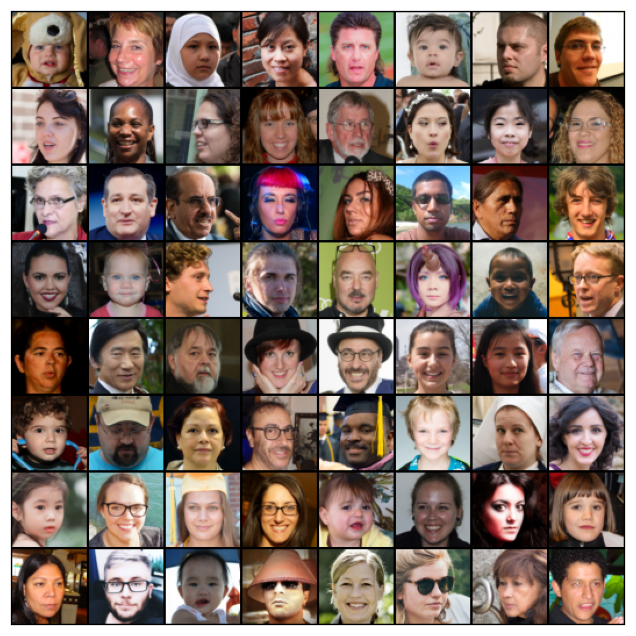

In [9]:
show_batch(train_dl)

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_dl = DeviceDataLoader(train_dl, device)

device

device(type='cuda')

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [12]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

In [13]:
latent_size = 128 # choose latent size

generator =  nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

generator = to_device(generator, device)

torch.Size([64, 3, 64, 64])


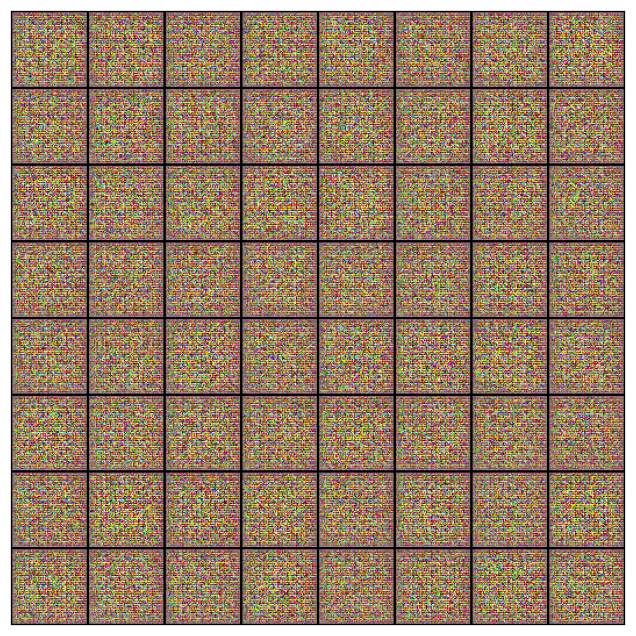

In [14]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
fake_images = generator(xb.to(device))
print(fake_images.shape)
show_images(fake_images.cpu())

In [15]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [16]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [17]:
epochs = 200
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),  
    "generator": nn.BCELoss()
}

In [18]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            # print('real_preds: ', real_preds.shape)
            # print('real_targets: ', real_targets.shape)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores
  # TODO: build optimizers and train your GAN
  

In [19]:
history = fit(model, criterion, epochs, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/200], loss_g: 5.3409, loss_d: 0.2468, real_score: 0.9115, fake_score: 0.1144


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/200], loss_g: 8.8080, loss_d: 0.0628, real_score: 0.9730, fake_score: 0.0290


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/200], loss_g: 13.8963, loss_d: 0.0674, real_score: 0.9758, fake_score: 0.0295


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/200], loss_g: 14.8650, loss_d: 0.1053, real_score: 0.9700, fake_score: 0.0396


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/200], loss_g: 10.7698, loss_d: 0.1311, real_score: 0.9550, fake_score: 0.0539


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/200], loss_g: 6.3499, loss_d: 0.2900, real_score: 0.9183, fake_score: 0.0718


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/200], loss_g: 5.4627, loss_d: 0.4556, real_score: 0.8520, fake_score: 0.1318


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/200], loss_g: 4.5889, loss_d: 0.2647, real_score: 0.8886, fake_score: 0.0964


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/200], loss_g: 4.9420, loss_d: 0.2682, real_score: 0.9030, fake_score: 0.0911


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/200], loss_g: 4.5639, loss_d: 0.3948, real_score: 0.8649, fake_score: 0.1308


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/200], loss_g: 4.9034, loss_d: 0.2447, real_score: 0.9029, fake_score: 0.0931


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/200], loss_g: 4.7915, loss_d: 0.3749, real_score: 0.8742, fake_score: 0.1175


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/200], loss_g: 5.4057, loss_d: 0.3433, real_score: 0.8936, fake_score: 0.1052


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/200], loss_g: 4.9288, loss_d: 0.2924, real_score: 0.8829, fake_score: 0.1092


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/200], loss_g: 5.0343, loss_d: 0.3946, real_score: 0.8797, fake_score: 0.1218


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/200], loss_g: 4.8630, loss_d: 0.1927, real_score: 0.9156, fake_score: 0.0812


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/200], loss_g: 5.2437, loss_d: 0.3732, real_score: 0.8716, fake_score: 0.1176


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/200], loss_g: 4.7625, loss_d: 0.2573, real_score: 0.9005, fake_score: 0.1021


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/200], loss_g: 5.0695, loss_d: 0.2985, real_score: 0.8963, fake_score: 0.0981


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/200], loss_g: 4.3500, loss_d: 0.2320, real_score: 0.9046, fake_score: 0.0941


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/200], loss_g: 4.3974, loss_d: 0.1894, real_score: 0.9206, fake_score: 0.0777


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/200], loss_g: 5.0875, loss_d: 0.3775, real_score: 0.8785, fake_score: 0.1152


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/200], loss_g: 4.5304, loss_d: 0.3304, real_score: 0.8790, fake_score: 0.1137


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/200], loss_g: 4.7921, loss_d: 0.2112, real_score: 0.9158, fake_score: 0.0889


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/200], loss_g: 4.5488, loss_d: 0.4082, real_score: 0.8656, fake_score: 0.1320


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/200], loss_g: 4.1451, loss_d: 0.2474, real_score: 0.8952, fake_score: 0.0958


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/200], loss_g: 4.3898, loss_d: 0.2282, real_score: 0.9029, fake_score: 0.0904


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/200], loss_g: 4.5339, loss_d: 0.4498, real_score: 0.8637, fake_score: 0.1388


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/200], loss_g: 4.3982, loss_d: 0.2330, real_score: 0.9057, fake_score: 0.0946


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/200], loss_g: 4.6100, loss_d: 0.4961, real_score: 0.8530, fake_score: 0.1439


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/200], loss_g: 3.9426, loss_d: 0.2301, real_score: 0.9002, fake_score: 0.0964


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/200], loss_g: 4.4023, loss_d: 0.2780, real_score: 0.8897, fake_score: 0.1037


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/200], loss_g: 4.2905, loss_d: 0.3252, real_score: 0.8830, fake_score: 0.1137


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/200], loss_g: 4.4409, loss_d: 0.2421, real_score: 0.9032, fake_score: 0.0971


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/200], loss_g: 4.4471, loss_d: 0.2508, real_score: 0.9039, fake_score: 0.0978


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/200], loss_g: 4.3055, loss_d: 0.3340, real_score: 0.8772, fake_score: 0.1136


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/200], loss_g: 4.5384, loss_d: 0.2078, real_score: 0.9147, fake_score: 0.0878


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/200], loss_g: 4.3132, loss_d: 0.1971, real_score: 0.9153, fake_score: 0.0827


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/200], loss_g: 4.9661, loss_d: 0.4878, real_score: 0.8528, fake_score: 0.1427


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/200], loss_g: 3.9651, loss_d: 0.2072, real_score: 0.9088, fake_score: 0.0894


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [41/200], loss_g: 4.4651, loss_d: 0.2596, real_score: 0.9029, fake_score: 0.0989


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [42/200], loss_g: 4.4573, loss_d: 0.2756, real_score: 0.8888, fake_score: 0.0995


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [43/200], loss_g: 4.3192, loss_d: 0.2582, real_score: 0.9001, fake_score: 0.1017


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [44/200], loss_g: 4.3351, loss_d: 0.2406, real_score: 0.9086, fake_score: 0.0916


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [45/200], loss_g: 4.5756, loss_d: 0.2707, real_score: 0.8931, fake_score: 0.1010


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [46/200], loss_g: 4.6740, loss_d: 0.2876, real_score: 0.8938, fake_score: 0.1069


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [47/200], loss_g: 4.2964, loss_d: 0.1939, real_score: 0.9176, fake_score: 0.0800


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [48/200], loss_g: 4.3094, loss_d: 0.1904, real_score: 0.9178, fake_score: 0.0777


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [49/200], loss_g: 4.7563, loss_d: 0.5785, real_score: 0.8417, fake_score: 0.1606


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50/200], loss_g: 4.0471, loss_d: 0.1581, real_score: 0.9276, fake_score: 0.0701


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [51/200], loss_g: 4.5567, loss_d: 0.1616, real_score: 0.9292, fake_score: 0.0709


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [52/200], loss_g: 5.0538, loss_d: 0.5441, real_score: 0.8483, fake_score: 0.1502


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [53/200], loss_g: 3.9212, loss_d: 0.2102, real_score: 0.9106, fake_score: 0.0893


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [54/200], loss_g: 4.1119, loss_d: 0.1554, real_score: 0.9298, fake_score: 0.0676


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [55/200], loss_g: 4.1092, loss_d: 0.2040, real_score: 0.9144, fake_score: 0.0804


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [56/200], loss_g: 4.2398, loss_d: 0.1594, real_score: 0.9303, fake_score: 0.0712


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [57/200], loss_g: 4.5628, loss_d: 0.3890, real_score: 0.8914, fake_score: 0.1101


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [58/200], loss_g: 4.2229, loss_d: 0.1582, real_score: 0.9280, fake_score: 0.0695


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [59/200], loss_g: 4.2113, loss_d: 0.1514, real_score: 0.9326, fake_score: 0.0655


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [60/200], loss_g: 4.6920, loss_d: 0.5305, real_score: 0.8537, fake_score: 0.1446


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [61/200], loss_g: 4.0122, loss_d: 0.1786, real_score: 0.9211, fake_score: 0.0771


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [62/200], loss_g: 4.0237, loss_d: 0.1519, real_score: 0.9327, fake_score: 0.0673


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [63/200], loss_g: 4.3767, loss_d: 0.4219, real_score: 0.8839, fake_score: 0.1094


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [64/200], loss_g: 4.1869, loss_d: 0.2046, real_score: 0.9180, fake_score: 0.0869


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [65/200], loss_g: 4.2193, loss_d: 0.1554, real_score: 0.9314, fake_score: 0.0669


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [66/200], loss_g: 4.3594, loss_d: 0.2340, real_score: 0.9104, fake_score: 0.0829


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [67/200], loss_g: 4.6140, loss_d: 0.3803, real_score: 0.8835, fake_score: 0.1187


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [68/200], loss_g: 3.9790, loss_d: 0.1482, real_score: 0.9326, fake_score: 0.0653


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [69/200], loss_g: 4.3564, loss_d: 0.1555, real_score: 0.9332, fake_score: 0.0677


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [70/200], loss_g: 4.3514, loss_d: 0.1445, real_score: 0.9353, fake_score: 0.0629


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [71/200], loss_g: 4.8993, loss_d: 0.5589, real_score: 0.8550, fake_score: 0.1454


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [72/200], loss_g: 3.9780, loss_d: 0.1772, real_score: 0.9205, fake_score: 0.0741


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [73/200], loss_g: 4.3286, loss_d: 0.1610, real_score: 0.9326, fake_score: 0.0688


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [74/200], loss_g: 4.4165, loss_d: 0.1530, real_score: 0.9351, fake_score: 0.0665


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [75/200], loss_g: 4.5255, loss_d: 0.1362, real_score: 0.9383, fake_score: 0.0593


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [76/200], loss_g: 4.3357, loss_d: 0.1403, real_score: 0.9380, fake_score: 0.0609


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [77/200], loss_g: 4.7023, loss_d: 0.5889, real_score: 0.8548, fake_score: 0.1439


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [78/200], loss_g: 4.2716, loss_d: 0.1693, real_score: 0.9265, fake_score: 0.0709


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [79/200], loss_g: 4.2885, loss_d: 0.1396, real_score: 0.9395, fake_score: 0.0623


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [80/200], loss_g: 4.1092, loss_d: 0.1280, real_score: 0.9385, fake_score: 0.0540


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [81/200], loss_g: 4.8370, loss_d: 0.4893, real_score: 0.8737, fake_score: 0.1313


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [82/200], loss_g: 4.1273, loss_d: 0.1383, real_score: 0.9368, fake_score: 0.0612


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [83/200], loss_g: 4.5005, loss_d: 0.1365, real_score: 0.9406, fake_score: 0.0598


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [84/200], loss_g: 4.3611, loss_d: 0.1294, real_score: 0.9422, fake_score: 0.0555


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [85/200], loss_g: 4.6265, loss_d: 0.1691, real_score: 0.9304, fake_score: 0.0693


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [86/200], loss_g: 4.7481, loss_d: 0.4896, real_score: 0.8796, fake_score: 0.1174


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [87/200], loss_g: 4.4395, loss_d: 0.2416, real_score: 0.9054, fake_score: 0.0939


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [88/200], loss_g: 4.2897, loss_d: 0.1394, real_score: 0.9386, fake_score: 0.0615


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [89/200], loss_g: 4.3773, loss_d: 0.1303, real_score: 0.9437, fake_score: 0.0586


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [90/200], loss_g: 4.4105, loss_d: 0.1430, real_score: 0.9354, fake_score: 0.0592


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [91/200], loss_g: 5.2516, loss_d: 0.3368, real_score: 0.8904, fake_score: 0.1088


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [92/200], loss_g: 4.6427, loss_d: 0.1736, real_score: 0.9301, fake_score: 0.0719


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [93/200], loss_g: 4.4462, loss_d: 0.1160, real_score: 0.9461, fake_score: 0.0489


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [94/200], loss_g: 5.2126, loss_d: 0.6199, real_score: 0.8488, fake_score: 0.1549


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [95/200], loss_g: 4.0406, loss_d: 0.1542, real_score: 0.9295, fake_score: 0.0655


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [96/200], loss_g: 4.5658, loss_d: 0.4249, real_score: 0.8806, fake_score: 0.1212


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [97/200], loss_g: 4.1682, loss_d: 0.1348, real_score: 0.9403, fake_score: 0.0601


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [98/200], loss_g: 4.3870, loss_d: 0.1168, real_score: 0.9479, fake_score: 0.0532


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [99/200], loss_g: 4.3405, loss_d: 0.1045, real_score: 0.9524, fake_score: 0.0484


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [100/200], loss_g: 4.7433, loss_d: 0.1467, real_score: 0.9344, fake_score: 0.0595


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [101/200], loss_g: 4.8025, loss_d: 0.5709, real_score: 0.8642, fake_score: 0.1402


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [102/200], loss_g: 4.1690, loss_d: 0.1457, real_score: 0.9324, fake_score: 0.0608


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [103/200], loss_g: 4.7647, loss_d: 0.2281, real_score: 0.9216, fake_score: 0.0801


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [104/200], loss_g: 4.3568, loss_d: 0.1293, real_score: 0.9438, fake_score: 0.0571


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [105/200], loss_g: 4.2707, loss_d: 0.1256, real_score: 0.9454, fake_score: 0.0567


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [106/200], loss_g: 4.4057, loss_d: 0.1278, real_score: 0.9406, fake_score: 0.0474


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [107/200], loss_g: 4.9759, loss_d: 0.6344, real_score: 0.8655, fake_score: 0.1408


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [108/200], loss_g: 4.3398, loss_d: 0.1453, real_score: 0.9375, fake_score: 0.0637


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [109/200], loss_g: 4.3982, loss_d: 0.1404, real_score: 0.9371, fake_score: 0.0591


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [110/200], loss_g: 4.5331, loss_d: 0.1166, real_score: 0.9495, fake_score: 0.0540


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [111/200], loss_g: 4.4742, loss_d: 0.1198, real_score: 0.9470, fake_score: 0.0536


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [112/200], loss_g: 4.8066, loss_d: 0.5286, real_score: 0.8880, fake_score: 0.1092


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [113/200], loss_g: 4.4024, loss_d: 0.2866, real_score: 0.8984, fake_score: 0.1037


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [114/200], loss_g: 4.1658, loss_d: 0.1294, real_score: 0.9411, fake_score: 0.0579


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [115/200], loss_g: 4.4659, loss_d: 0.1542, real_score: 0.9320, fake_score: 0.0610


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [116/200], loss_g: 4.8840, loss_d: 0.3607, real_score: 0.8979, fake_score: 0.1080


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [117/200], loss_g: 4.4817, loss_d: 0.1589, real_score: 0.9340, fake_score: 0.0664


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [118/200], loss_g: 4.3116, loss_d: 0.1090, real_score: 0.9492, fake_score: 0.0490


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [119/200], loss_g: 4.5855, loss_d: 0.1108, real_score: 0.9510, fake_score: 0.0494


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [120/200], loss_g: 4.4683, loss_d: 0.1192, real_score: 0.9442, fake_score: 0.0479


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [121/200], loss_g: 5.4650, loss_d: 0.6046, real_score: 0.8623, fake_score: 0.1454


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [122/200], loss_g: 4.4244, loss_d: 0.1321, real_score: 0.9416, fake_score: 0.0592


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [123/200], loss_g: 4.3529, loss_d: 0.1259, real_score: 0.9440, fake_score: 0.0541


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [124/200], loss_g: 4.4739, loss_d: 0.1168, real_score: 0.9479, fake_score: 0.0510


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [125/200], loss_g: 4.5054, loss_d: 0.1216, real_score: 0.9469, fake_score: 0.0517


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [126/200], loss_g: 4.2969, loss_d: 0.1208, real_score: 0.9436, fake_score: 0.0480


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [127/200], loss_g: 4.8479, loss_d: 0.7103, real_score: 0.8561, fake_score: 0.1536


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [128/200], loss_g: 4.2381, loss_d: 0.1350, real_score: 0.9391, fake_score: 0.0583


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [129/200], loss_g: 4.2963, loss_d: 0.1043, real_score: 0.9528, fake_score: 0.0477


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [130/200], loss_g: 4.2987, loss_d: 0.1071, real_score: 0.9508, fake_score: 0.0478


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [131/200], loss_g: 4.5725, loss_d: 0.1151, real_score: 0.9488, fake_score: 0.0500


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [132/200], loss_g: 4.6397, loss_d: 0.1128, real_score: 0.9512, fake_score: 0.0502


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [133/200], loss_g: 4.6832, loss_d: 0.1071, real_score: 0.9554, fake_score: 0.0483


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [134/200], loss_g: 5.0960, loss_d: 0.5359, real_score: 0.8655, fake_score: 0.1289


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [135/200], loss_g: 4.7358, loss_d: 0.1575, real_score: 0.9359, fake_score: 0.0658


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [136/200], loss_g: 4.3931, loss_d: 0.1230, real_score: 0.9435, fake_score: 0.0506


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [137/200], loss_g: 5.2028, loss_d: 0.4666, real_score: 0.8778, fake_score: 0.1272


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [138/200], loss_g: 4.6275, loss_d: 0.1241, real_score: 0.9453, fake_score: 0.0550


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [139/200], loss_g: 4.5000, loss_d: 0.0930, real_score: 0.9570, fake_score: 0.0425


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [140/200], loss_g: 4.5666, loss_d: 0.0882, real_score: 0.9586, fake_score: 0.0395


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [141/200], loss_g: 4.6541, loss_d: 0.0933, real_score: 0.9579, fake_score: 0.0429


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [142/200], loss_g: 4.6932, loss_d: 0.1100, real_score: 0.9519, fake_score: 0.0477


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [143/200], loss_g: 4.8698, loss_d: 0.1056, real_score: 0.9542, fake_score: 0.0459


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [144/200], loss_g: 4.4893, loss_d: 0.0911, real_score: 0.9558, fake_score: 0.0341


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [145/200], loss_g: 4.9557, loss_d: 0.7400, real_score: 0.8564, fake_score: 0.1533


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [146/200], loss_g: 4.3310, loss_d: 0.1434, real_score: 0.9356, fake_score: 0.0554


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [147/200], loss_g: 4.6950, loss_d: 0.5359, real_score: 0.8691, fake_score: 0.1328


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [148/200], loss_g: 4.7079, loss_d: 0.2362, real_score: 0.9155, fake_score: 0.0797


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [149/200], loss_g: 4.7686, loss_d: 0.3289, real_score: 0.9143, fake_score: 0.0939


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [150/200], loss_g: 4.5367, loss_d: 0.1269, real_score: 0.9444, fake_score: 0.0518


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [151/200], loss_g: 4.8796, loss_d: 0.2217, real_score: 0.9247, fake_score: 0.0796


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [152/200], loss_g: 4.6114, loss_d: 0.0903, real_score: 0.9582, fake_score: 0.0418


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [153/200], loss_g: 4.5980, loss_d: 0.0844, real_score: 0.9608, fake_score: 0.0392


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [154/200], loss_g: 4.6539, loss_d: 0.0815, real_score: 0.9621, fake_score: 0.0376


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [155/200], loss_g: 4.5470, loss_d: 0.0977, real_score: 0.9530, fake_score: 0.0388


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [156/200], loss_g: 5.2299, loss_d: 0.5362, real_score: 0.8936, fake_score: 0.1141


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [157/200], loss_g: 4.4473, loss_d: 0.1021, real_score: 0.9529, fake_score: 0.0455


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [158/200], loss_g: 4.4314, loss_d: 0.0888, real_score: 0.9587, fake_score: 0.0395


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [159/200], loss_g: 4.8042, loss_d: 0.1034, real_score: 0.9547, fake_score: 0.0448


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [160/200], loss_g: 4.6941, loss_d: 0.0896, real_score: 0.9586, fake_score: 0.0394


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [161/200], loss_g: 5.5936, loss_d: 0.6114, real_score: 0.8575, fake_score: 0.1469


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [162/200], loss_g: 4.7688, loss_d: 0.1330, real_score: 0.9417, fake_score: 0.0567


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [163/200], loss_g: 4.7682, loss_d: 0.1109, real_score: 0.9533, fake_score: 0.0499


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [164/200], loss_g: 4.5250, loss_d: 0.0735, real_score: 0.9651, fake_score: 0.0342


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [165/200], loss_g: 4.5929, loss_d: 0.0706, real_score: 0.9656, fake_score: 0.0321


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [166/200], loss_g: 4.7703, loss_d: 0.0881, real_score: 0.9619, fake_score: 0.0395


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [167/200], loss_g: 5.1366, loss_d: 0.1620, real_score: 0.9388, fake_score: 0.0598


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [168/200], loss_g: 4.8580, loss_d: 0.0780, real_score: 0.9634, fake_score: 0.0354


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [169/200], loss_g: 4.9993, loss_d: 0.0783, real_score: 0.9657, fake_score: 0.0363


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [170/200], loss_g: 5.6956, loss_d: 0.3260, real_score: 0.9019, fake_score: 0.0984


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [171/200], loss_g: 4.8612, loss_d: 0.0964, real_score: 0.9532, fake_score: 0.0366


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [172/200], loss_g: 5.2481, loss_d: 0.5271, real_score: 0.8924, fake_score: 0.1168


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [173/200], loss_g: 4.5197, loss_d: 0.1124, real_score: 0.9515, fake_score: 0.0485


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [174/200], loss_g: 4.6058, loss_d: 0.0791, real_score: 0.9628, fake_score: 0.0360


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [175/200], loss_g: 4.6773, loss_d: 0.0665, real_score: 0.9689, fake_score: 0.0318


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [176/200], loss_g: 4.8427, loss_d: 0.0671, real_score: 0.9684, fake_score: 0.0311


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [177/200], loss_g: 4.9601, loss_d: 0.0610, real_score: 0.9719, fake_score: 0.0295


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [178/200], loss_g: 4.9362, loss_d: 0.0590, real_score: 0.9711, fake_score: 0.0267


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [179/200], loss_g: 5.0234, loss_d: 0.0681, real_score: 0.9698, fake_score: 0.0315


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [180/200], loss_g: 5.2466, loss_d: 0.0612, real_score: 0.9705, fake_score: 0.0271


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [181/200], loss_g: 5.3216, loss_d: 0.1572, real_score: 0.9430, fake_score: 0.0573


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [182/200], loss_g: 5.0350, loss_d: 0.0843, real_score: 0.9626, fake_score: 0.0376


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [183/200], loss_g: 5.0425, loss_d: 0.0857, real_score: 0.9619, fake_score: 0.0376


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [184/200], loss_g: 5.1238, loss_d: 0.0625, real_score: 0.9709, fake_score: 0.0290


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [185/200], loss_g: 5.1877, loss_d: 0.1195, real_score: 0.9621, fake_score: 0.0464


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [186/200], loss_g: 5.4094, loss_d: 0.7158, real_score: 0.8588, fake_score: 0.1294


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [187/200], loss_g: 5.5658, loss_d: 0.3742, real_score: 0.8993, fake_score: 0.1076


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [188/200], loss_g: 4.7892, loss_d: 0.1043, real_score: 0.9545, fake_score: 0.0459


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [189/200], loss_g: 4.6124, loss_d: 0.0861, real_score: 0.9590, fake_score: 0.0366


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [190/200], loss_g: 5.2544, loss_d: 0.1800, real_score: 0.9376, fake_score: 0.0655


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [191/200], loss_g: 4.8126, loss_d: 0.0701, real_score: 0.9679, fake_score: 0.0330


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [192/200], loss_g: 4.8747, loss_d: 0.0615, real_score: 0.9699, fake_score: 0.0276


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [193/200], loss_g: 4.9749, loss_d: 0.0760, real_score: 0.9653, fake_score: 0.0337


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [194/200], loss_g: 5.1613, loss_d: 0.0725, real_score: 0.9671, fake_score: 0.0326


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [195/200], loss_g: 5.8838, loss_d: 0.7051, real_score: 0.8619, fake_score: 0.1431


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [196/200], loss_g: 4.7886, loss_d: 0.1052, real_score: 0.9520, fake_score: 0.0457


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [197/200], loss_g: 4.8103, loss_d: 0.0894, real_score: 0.9587, fake_score: 0.0382


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [198/200], loss_g: 5.0196, loss_d: 0.1058, real_score: 0.9576, fake_score: 0.0461


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [199/200], loss_g: 4.8591, loss_d: 0.0580, real_score: 0.9725, fake_score: 0.0277


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [200/200], loss_g: 5.0816, loss_d: 0.0592, real_score: 0.9717, fake_score: 0.0273
Saving generated-images-0200.png


In [20]:
losses_g, losses_d, real_scores, fake_scores = history

In [22]:
generated_img = cv2.imread(f'./generated/generated-images-0{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

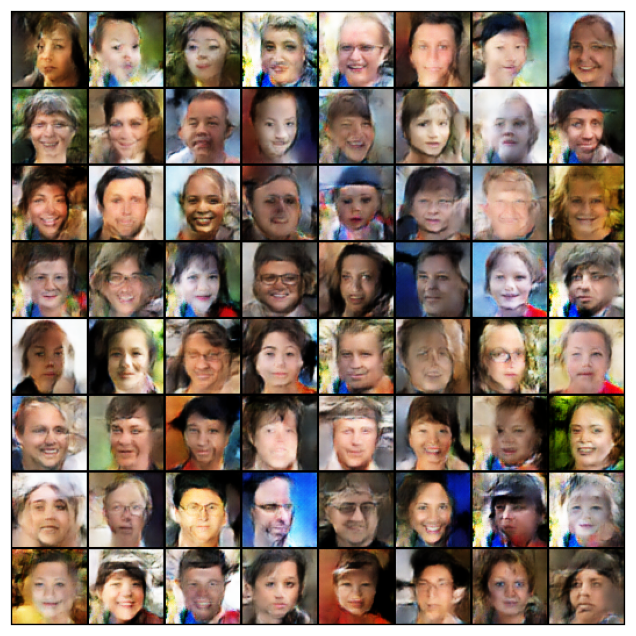

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

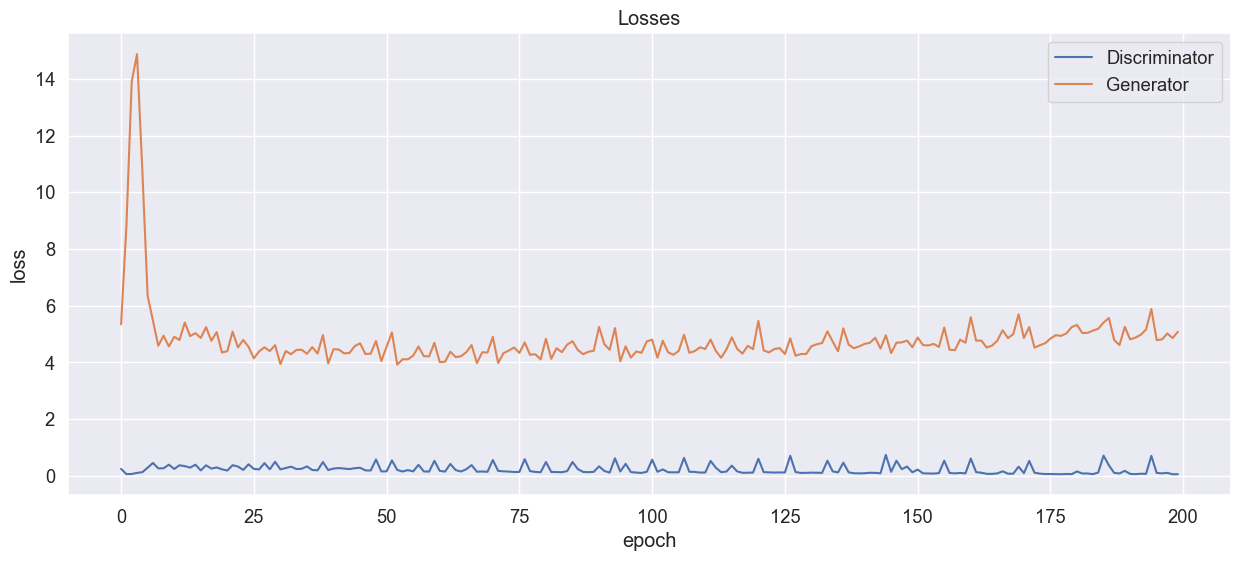

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

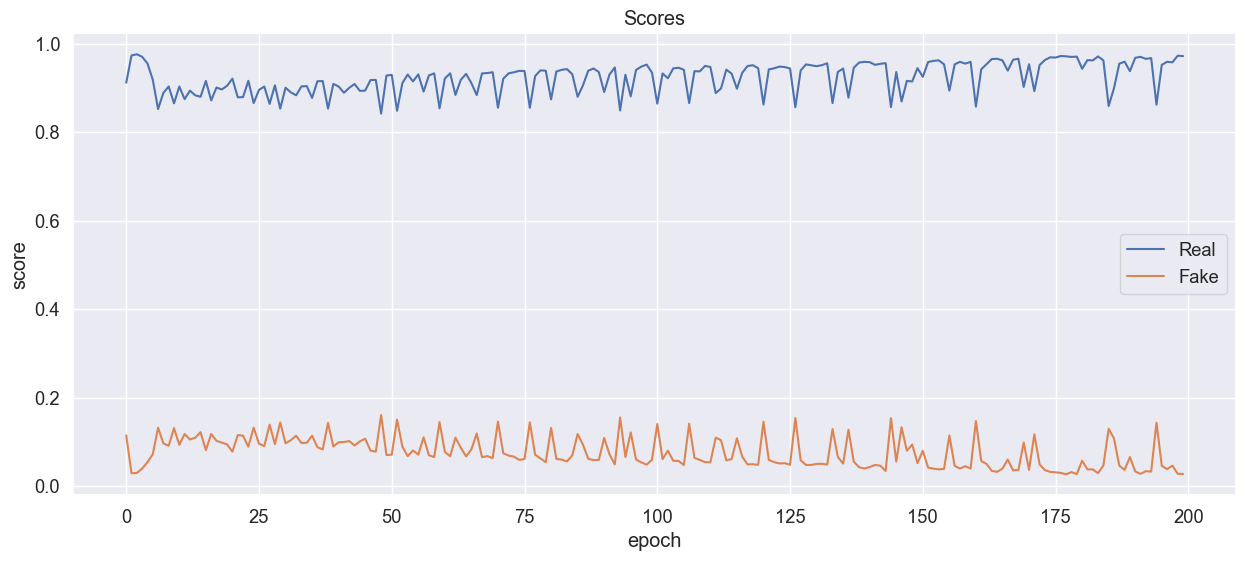

In [25]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [48]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images_pre = model["generator"](fixed_latent)
fake_images_pre = np.rollaxis(fake_images_pre.cpu().detach().numpy(), 1, 4)


In [49]:
reshape = tt.Compose([tt.Resize(image_size), tt.CenterCrop(image_size)])

def show(image, label = 'none', num = 1, z = 9):
    for k in range(num):
        plt.subplot(1, num, k+1)
        plt.imshow(image[z+k])
        plt.title(label)
        plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


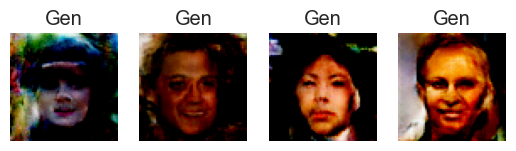

In [50]:
show(fake_images_pre, label = 'Gen', num = n_images, z = 0)

Как вам качество получившихся изображений?

Не очень.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [51]:
# Generate fake images.
latent2 = torch.randn(1000, latent_size, 1, 1, device=device)
fake_images = model["generator"](latent2)
# Reshape.
fake_images = reshape(fake_images) 
# Change axis.
fake_images = np.rollaxis(fake_images.cpu().detach().numpy(), 1, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


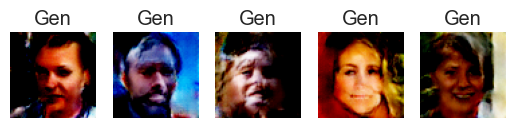

In [52]:
show(fake_images, label = 'Gen', num = 5, z = 22)

In [53]:
# Get real images.
real_images = [i[0] for i in tqdm(train_ds)][:1000]
np_img = np.array([torch.Tensor.numpy(img) for img in real_images])
np_img = np.rollaxis(np_img, 1, 4)


  0%|          | 0/3143 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


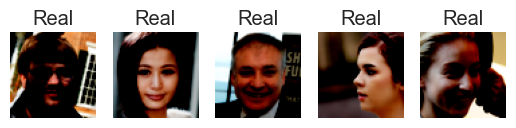

In [54]:
show(np_img, label = 'Real', num = 5, z = 88)

In [55]:
# Объеденяем реальные и сгенерироывнные изображения.
X_img = np.concatenate((np_img, fake_images))
y_img = np.concatenate((np.ones(1000), np.zeros(1000)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


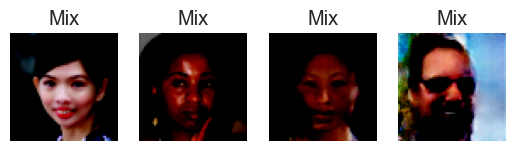

In [56]:
show(X_img, label = 'Mix', num = 4, z = 998)

In [57]:
def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [ ]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
# Leave-One-Out cross-validator  - это простая перекрестная проверка(cross-validation). Каждый обучающий набор создается путем взятия всех образцов, 
# кроме одного, тестовый набор является пропущенным образцом. Таким образом, для образцов у нас есть разные обучающие наборы и
# разные наборы тестов. Эта процедура перекрестной проверки не приводит к потере большого количества данных, поскольку из обучающего 
# набора удаляется только один образец. Предоставляет индексы train/test для разделения данных в наборах train/test. 
# Каждая выборка используется один раз в качестве тестового набора (одиночный элемент), в то время как остальные выборки формируют обучающий набор.
from sklearn.neighbors import KNeighborsClassifier

# Обьявляем cross-validator
loo = LeaveOneOut()

# get_n_splits - Returns the number of splitting iterations in the cross-validator
print('loo.get_n_splits(X_img): ' ,loo.get_n_splits(X_img))


# k-nearest neighbors classifier
neigh = KNeighborsClassifier(n_neighbors=1)

score = []

# cross-validator разбивает обучающую выборку на батчи и в цикле итерируемся по ним.
# loo.split - Generate indices to split data into training and test set.
for i, (train_index, test_index) in enumerate(loo.split(X_img)):
    #print(f"Fold {i}:")

    X_train_iter = []
    y_train_iter = []

    X_test_iter = []
    y_test_iter = []
    

    for i in train_index:
        # print(f"X[i]X[i] {X_img[i].reshape(-1)}:")
        X_train_iter.append(X_img[i].reshape(-1))
        y_train_iter.append(y_img[i])

    for i in test_index:    
        X_test_iter.append(X_img[i].reshape(-1))
        y_test_iter.append(y_img[i])
    # Записываем score для каждой итерации.
    score.append(get_score(neigh, X_train_iter, X_test_iter, y_train_iter, y_test_iter))

print('score: ', score)


loo.get_n_splits(X_img):  2000


In [364]:
# Так как у нас записан score для каждой итерации расчитаем средний score.

all = 0
count = 0

for s in score:
    all += s
    count += 1

print('Final score: ', all/count)    

Final score:  0.843


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Final score:  0.843, как я понял, то чем меньше score, тем лучше модель генерирует изображение.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

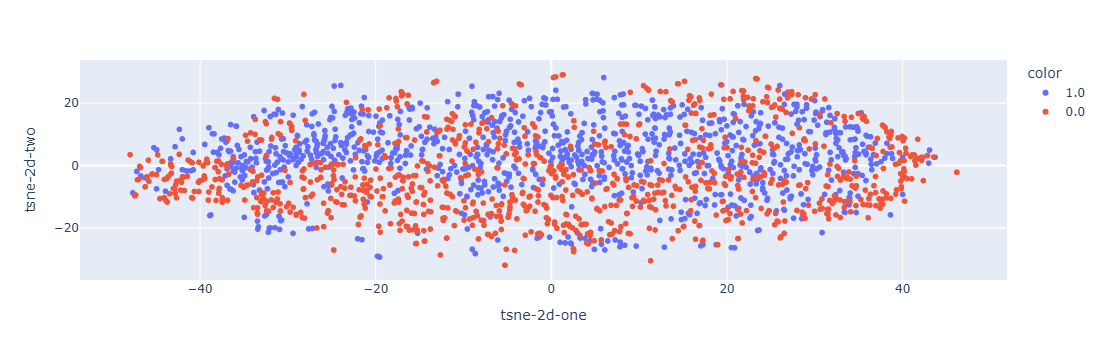

In [369]:
from sklearn.manifold import TSNE
import plotly.express as px

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X_img.reshape(2000, -1))

fig = px.scatter(tsne_results, x=0, y=1, color=y_img.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

Прокомментируйте получившийся результат:

In [ ]:
# Видно что синии точки плохо перемешались с красными, предпологаю что чем лучше изображение 
# генерирует генератор, тем сложнее отделить красные от синих точек.